# Protein Sequence Classification using 1D Convolutions

###### This project aims at classifying protein sequences by performing sentiment analysis using 1D Convolutions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_pdb_data_no_seq = pd.read_csv('resources/pdb_data_no_dups.csv')
df_pdb_seq = pd.read_csv('resources/pdb_data_seq.csv')
print("..Read data files..")

..Read data files..


In [3]:
# filtering out only protein structures
df_protein_seq = df_pdb_seq[(df_pdb_seq['macromoleculeType'] == 'Protein')]

In [4]:
# joining two data sets for protein Seq - classification

df_protein_final = df_protein_seq.merge(df_pdb_data_no_seq)

df_protein_seq_final = df_protein_final[['sequence', 'classification']]

df_protein_seq_final.head()

,sequence,classification
0,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,OXYGEN TRANSPORT
1,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,HYDROLASE(O-GLYCOSYL)
2,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,OXYGEN TRANSPORT
3,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...,HYDROLASE(O-GLYCOSYL)
4,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,OXYGEN TRANSPORT


In [5]:
df_protein_seq_final = df_protein_seq_final.dropna()
print("filtered data with NA values")

filtered data with NA values


In [6]:
from utilities.EmbeddingEncoder import EmbeddingEncoder

embed_enoder = EmbeddingEncoder()

embed_enoder.find_unique_amino_acids(df_protein_seq_final['sequence'])
print("Unique Amino Acid Set...")

Unique Amino Acid Set...


In [7]:
embed_enoder.create_embed_encoder()
print(embed_enoder.embed_encoder)

{'C': 0, 'I': 1, 'B': 2, 'L': 3, 'U': 4, 'H': 5, 'T': 6, 'F': 7, 'V': 8, 'W': 9, 'E': 10, 'K': 11, 'O': 12, 'D': 13, 'Z': 14, 'M': 15, 'Q': 16, 'P': 17, 'R': 18, 'X': 19, 'S': 20, 'Y': 21, 'G': 22, 'N': 23, 'A': 24}


In [8]:
from utilities.DataPreProcessor import DataPreProcessor

count_dict = df_protein_seq_final['classification'].value_counts().to_dict()
data_pre_processor = DataPreProcessor(count_dict,embed_enoder,None)

In [9]:
## delete least preferred sequences
data_pre_processor.del_least_preferred()

df_protein_seq_final_for_modeling = \
    df_protein_seq_final[df_protein_seq_final['classification']
        .isin(data_pre_processor.count_dict_keys_as_list())]

df_protein_seq_final_for_modeling = \
    df_protein_seq_final_for_modeling.reset_index(drop=True)
print("final Shape of the DataSet {}".format(df_protein_seq_final_for_modeling.shape))

final Shape of the DataSet (291355, 2)


In [10]:
## only considering sequences of length between 50 and 1200
df_protein_seq_final_for_modeling = \
    df_protein_seq_final_for_modeling[df_protein_seq_final_for_modeling.apply(
        lambda x: len(x['sequence']) <=1200 and len(x['sequence']) >=50 ,axis=1
    )]

In [11]:
print("final Shape of the DataSet {}".format(df_protein_seq_final_for_modeling.shape))

final Shape of the DataSet (271914, 2)


In [12]:
X_sequences = df_protein_seq_final_for_modeling['sequence']
y_label = df_protein_seq_final_for_modeling['classification']

In [13]:
## test process sequences

data_pre_processor.process_seqs_to_embeddings(X_sequences,y_label,1200)
print("Getting Processed Seqs")
print(data_pre_processor.get_x().shape)
print("getting labels")
print(data_pre_processor.get_y().shape)
# print("getting protein categories")
# print(data_pre_processor.get_protein_categoeies())

Getting Processed Seqs
(271914, 1200)
getting labels
(271914, 61)


## LSTM Modeling

In [14]:
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import SpatialDropout1D
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint

/home/aind2/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [15]:
embed_vol = 5000
embed_dim = 300
num_features = 25
max_seq_length = 1200
## AAs are supposed to be integer encoded for embedding layer 

model = Sequential()
model.add(Embedding(embed_vol,embed_dim,input_length=data_pre_processor.get_x().shape[1]))
model.add(BatchNormalization())
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(len(data_pre_processor.get_protein_categoeies()),activation='softmax'))
model.add(Dropout(0.2))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1200, 300)         1500000   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1200, 300)         1200      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1198, 32)          28832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 599, 32)           0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 599, 32)           128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 597, 64)           6208      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 298, 64)           0         
__________

## Test-Train Split

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_pre_processor.get_x(), data_pre_processor.get_y(), test_size=0.20, random_state=42)

In [17]:
print("train data shape is {} and {}".format(X_train.shape,y_train.shape))
print("test data shape is {} and {}".format(X_test.shape,y_test.shape))

train data shape is (217531, 1200) and (217531, 61)
test data shape is (54383, 1200) and (54383, 61)


In [18]:
# from keras.callbacks import TensorBoard

# tensor_board = TensorBoard(log_dir='logs/Graph', histogram_freq=0, write_graph=True, write_images=True)

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/best_weights_cnn.hdf5', 
                               verbose=1, save_best_only=True)

## Fit the Model (Training with validation split)

Train on 174024 samples, validate on 43507 samples
Epoch 1/15
 - 219s - loss: 4.7933 - acc: 0.4665 - val_loss: 2.2896 - val_acc: 0.4922
Epoch 2/15
 - 215s - loss: 4.1354 - acc: 0.5724 - val_loss: 7.0898 - val_acc: 0.1307
Epoch 3/15
 - 215s - loss: 3.9718 - acc: 0.6129 - val_loss: 4.2523 - val_acc: 0.3701
Epoch 4/15
 - 215s - loss: 3.8682 - acc: 0.6376 - val_loss: 1.9323 - val_acc: 0.6036
Epoch 5/15
 - 215s - loss: 3.7966 - acc: 0.6533 - val_loss: 1.4817 - val_acc: 0.6612
Epoch 6/15
 - 215s - loss: 3.7384 - acc: 0.6664 - val_loss: 1.3049 - val_acc: 0.7157
Epoch 7/15
 - 215s - loss: 3.7334 - acc: 0.6741 - val_loss: 1.3795 - val_acc: 0.7010
Epoch 8/15
 - 215s - loss: 3.6877 - acc: 0.6811 - val_loss: 1.1714 - val_acc: 0.7527
Epoch 9/15
 - 214s - loss: 3.6481 - acc: 0.6885 - val_loss: 1.2975 - val_acc: 0.7188
Epoch 10/15
 - 214s - loss: 3.6368 - acc: 0.6935 - val_loss: 1.0580 - val_acc: 0.7903
Epoch 11/15
 - 214s - loss: 3.6243 - acc: 0.6970 - val_loss: 1.3278 - val_acc: 0.7258
Epoch 12/15


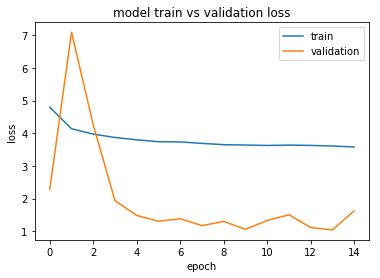

In [19]:
history = model.fit(X_train,y_train,epochs=15,verbose=2,batch_size=32,validation_split=0.2,callbacks=[checkpointer])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [20]:
score,acc = model.evaluate(X_test, y_test, verbose = 2, batch_size = 16)
print("Score: %.2f" % (score))
print("Validation Accuracy: %.2f" % (acc))

Score: 1.62
Validation Accuracy: 0.67


## More Training

In [21]:
# history = model.fit(X_train,y_train,epochs=5,verbose=2,batch_size=32,validation_split=0.2)

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model train vs validation loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper right')
# plt.show()

In [22]:
# score,acc = model.evaluate(X_test, y_test, verbose = 2, batch_size = 16)
# print("Score: %.2f" % (score))
# print("Validation Accuracy: %.2f" % (acc))